# La Habana; sinonimo de calidad, perfeccion, vivencias.

La Habana es una ciudad vibrante y llena de historia, un crisol de culturas que se refleja en su rica y diversa gastronomia, que se puede observar en sus calles y barrios. Este proyecto busca analizar y explorar los datos obtenidos de multiples restaurantes y bares de todos los municipios de esta provincia.

Comencemos importando las diferentes bibliotecas que se usaran en el proyecto, ademas de guardar la ruta de los diferentes archivos JSON, para que posteriormente sean cargados por la variable info.

In [56]:
# Con estas 2 lineas hacemos un autoreload a los scripts externos, 
# y nos ahorramos a estarle dando restart cada vez que cambiemos algo
%load_ext autoreload
%autoreload 2

from src.utils.filesManagement import load_json, extract_info
from src.utils.funcs import get_municipe_by_id, drill_schedule
from src.utils.graphs import general_graph, graph_bar_by_zone
import glob
import pandas as pd
import matplotlib.pyplot as plt
import folium as fl
import seaborn as sns

MAIN_PATH = ".\\src\\files\\"

info_paths = []
GEOJSON_DATA = load_json(MAIN_PATH + "helps\\lha.geojson")

for municipe_path in glob.glob(MAIN_PATH + "restaurants\\*"):
    for jsons in glob.glob(municipe_path + "\\*.json"):
        info_paths.append(jsons)

info = []

for information in info_paths:
    info.extend(extract_info(information))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ¿Pero algo como que no cuadra?

¿Que mas da hacer el analisis de estos Restaurantes/Bares si no los tenemos ubicados geograficamente? Y no es por nada, pero muchas personas se pierden con las direcciones, y no tienen la paciencia para estar preguntando, ni el tiempo del mundo para estar recorriendo La Habana las 24 horas; por tanto debemos de aprovechar las tecnologias de hoy en dia, y ubicaremos geograficamente los locales para que sean mas faciles de identificar, aunque, no solo sera la posicion geografica, eso no nos sirve mas que para veros en un mapa, si no sabemos el nombre de a donde estamos yendo, ni que tipo de cocina tiene, en que horario opera, o incluso en que municipio esta, porque si, puedes saber cuales son los municipios de la capital, pero tal vez no sepas donde estan, o que limites tienen con otros municipios.

In [57]:
LA_HABANA_COORDINATES = (23.0540698, -82.345189)

lh = fl.Map(
    location=LA_HABANA_COORDINATES,
    zoom_start=11.4,
    min_zoom=8
)

fl.GeoJson(
    GEOJSON_DATA,
    zoom_on_click=True,
    highlight_function=lambda _: {
        "fillColor": "#fff",
    }
).add_to(lh)

for i in range(len(info)):
    
    styles = """
    <style>
        * {
            text-align: center;
            color: #3D3D3D;
        }
        body {
            border-radius: 50%;
        }
        h4 {
            font-size: large;
        }
        li {
            list-style: none;
        }
    
    </style>
    """
    
    html = f"""
    <h1 class='nameHeader'>{info[i]["name"]}</h1>
    <h4 class='municipalityHeader'>{get_municipe_by_id(info[i]["municipality"])}</h4>
    <h4>Cocina(s): {", ".join(info[i]["cuisine"])}</h4>
    """
    popup_html = f"""
    <h4>Horarios (Se expresan en formato 24H)</h4>
    <ul>
        {drill_schedule(info[i]["schedules"])}
    </ul>
    """
    iframe = fl.IFrame(str(styles + html + popup_html), width=250, height=250)
    popup = fl.Popup(iframe, max_width=500)
    fl.Marker(
        location=info[i]["coordinates"],
        icon=fl.Icon(prefix="fa", icon='utensils', color="orange"),
        tooltip=html,
        popup=popup
    ).add_to(lh)

lh

## ¿Y el tipo de cocina?, es un tema bastante importante a tocar

Es cierto, todo el mundo tiene sus gustos, y quiere saber que, si va a algun municipio de nuestra querida Habana, que al menos el tipo de comida mas popular, el que mas tienden a ofrecer los restaurantes sea el de su agrado; por tanto, observemos cual tipo de cocina es el mas ofrecido, primeramente en general, o sea en toda La Habana y luego en todos y cada uno de los municipios de esta.

In [58]:
general_cuisine = [place_cuisine for infos in info for place_cuisine in infos["cuisine"]]

def filter_lists(main_list: list, key: str):
    mun_with_info = {}

    for item in main_list:
        if item.get(key) is not None:
            municipality = item["municipality"]

            if municipality in mun_with_info:
                mun_with_info[municipality].extend(item[key])
            else:
                mun_with_info[municipality] = item[key]

    result = [{municipality: new_filter} for municipality, new_filter in mun_with_info.items()]

    return result

cuisine_mun = filter_lists(info, "cuisine")
# print(cuisine_mun)
data = []
for cuisines_and_mun in cuisine_mun:
    for keys, values in cuisines_and_mun.items():
        mun_name = get_municipe_by_id(keys)
        mun_modes = ", ".join(pd.Series(values).mode())
        
        data.append({"Municipio": mun_name, "Comida Predominante": mun_modes})
        
df_general = pd.DataFrame({
    "Provincia": ["La Habana"],
    "Comida Predominante": [", ".join(pd.Series(general_cuisine).mode())]
})

df_municipalities = pd.DataFrame(data)

display(df_general)
display(df_municipalities)

,Provincia,Comida Predominante
0,La Habana,Criolla


,Municipio,Comida Predominante
0,Arroyo Naranjo,Criolla
1,Boyeros,Cubana
2,Centro Habana,Cubana
3,Cerro,Italiana
4,Cotorro,"Criolla, Italiana"
5,Diez de Octubre,Criolla
6,Guanabacoa,"Criolla, Italiana"
7,La Habana del Este,Criolla
8,La Habana Vieja,Criolla
9,La Lisa,Criolla


<p>Como se puede observar, la comida <span style='color: #C4895C;'>criolla</span> es la que predomina en toda la capital, demostrando que se mantienen las tradiciones y los metodos culinarios de la idiosincrasia de nuestro pais, en el tema de los municipios, se refuerza esta afirmacion, ya que la mayoria de municipios tienen a la comida <span style='color: #C4895C;'>criolla</span> como su maximo exponente, consolidando su importancia en la dieta y cultura local; sin embargo notamos interesantes excepciones, como lo son Boyeros y Centro Habana que ofrecen la comida <span style='color: #CF1E33;'>cubana</span> en la mayoria de sus restaurantes, los cuales tal vez este tipo de comida sean los predominantes por el tema del turismo; en el Cerro se hace demasiado notable la influencia <span style='color: #008C45;'>italiana</span>. Pero no solo Boyeros y Centro Habana serian los buscados por los turistas, aqui han de destacar tambien Playa y Regla, ofreciendo comida <span style='color: #00A3E0;'>internacional</span> la mayoria de sus restaurantes y bares, y bueno, tambien tenemos el caso atipico de Plaza de la Revolucion, donde hay un empate de la <span style='color: #FF8C00;'>cocteleria</span> con la comida <span style='color: #C4895C;'>criolla</span>, aunque no es el unico empatado, en Guanabacoa y Cotorro volvemos a ver otro empate, pero esta vez entre la comida predominante por excelencia en toda la capital, y la comida del <a href='https://es.wikipedia.org/wiki/Bel_paese'>Bel paese</a>; dandonos en segundo lugar como el mas repetido por los restaurantes de La Habana a el tipo de comida <span style='color: #008C45;'>italiana</span></p>

In [59]:
df = pd.DataFrame(info)
df.describe()

,name,municipality,coordinates,cuisine,services,payment,schedules,food,drinks
count,193,193,193,193,193,193,193,192,165
unique,165,15,165,67,4,5,70,164,135
top,,HV,"[0, 0]",[Criolla],"{'a_la_carte': True, 'reservation': False, 'de...","{'cash': True, 'transfer': True, 'currency': {...","{'monday': {'start_time': '12:00', 'end_time':...",[],[]
freq,29,30,29,66,89,162,47,29,29


Usaremos **.describe()** para que nos haga un informe detallado de lo que tenemos a mano

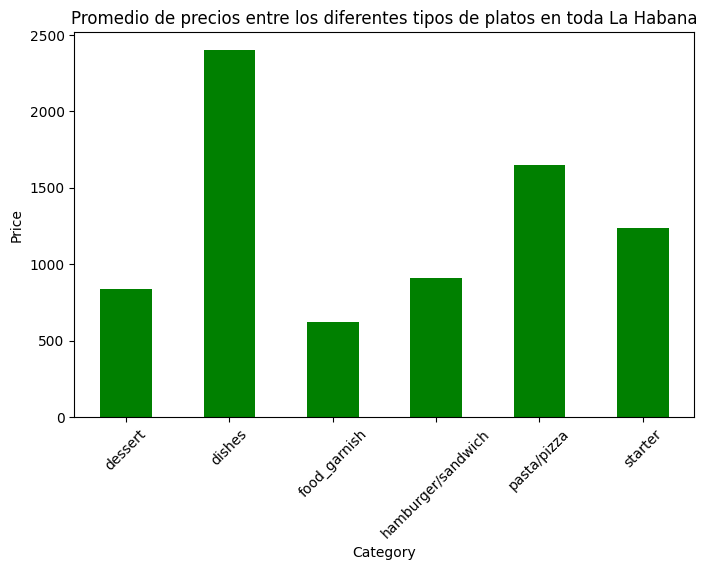

In [60]:
def process_food(data_list: list):
  food = []
  for item in data_list:
    if item.get("food") is not None:
        for food_item in item.get("food"):
            food.append({
                "category": food_item["category"],
                "price": food_item["price"]
            })

  food_df = pd.DataFrame(food)
  grouped_food = food_df.groupby("category")["price"].mean()
  
  return grouped_food


general_graph(process_food(info))

## ¿En realidad importa el tipo de comida para que sea mas cara/barata?

Este analisis de precios promedio en diferentes categorias de platos en La Habana revela una jerarquia clara. La tabla la lideran los **platos principales ("dishes")** con un precio promedio significativamente alto, rondando entre los 2000 y 2500 CUP, al ser los que las personas generalmente van a consumir, llevar, o pedir a domicilio, ademas que son los que mayor preparacion e ingredientes llevan.

Le sigue luego las **pastas y las pizzas ("pasta/pizza")**, que su promedio sobrepasa los 1500 CUP, esto se relaciona a la mayoria de restaurantes italianos que tiene la ciudad, los cuales ofrecen calidad, fidelidad y perfeccion en cuanto a pastas y pizzas se refiere.

Otras categorias como los **entrantes ("starter")** y los **postres ("dessert")** muestran precios promedio por debajo de los 1500 y 1000 CUP respectivamente, lo que representan opciones mucho mas economicas para el consumidor, ademas de ser estos el abridor y cerrador de la mayoria de comida de las personas.

Por ultimo, tenemos a las **hamburguesas y sandwiches ("hamburger/sandwich")** y a las **guarniciones ("food_garnish")**, son los platos con los precios promedio mas bajos de todas las categorias, teniendo precios por debajo de 1000 CUP, mostrandose asimismos como platos complementarios.

### Muy bien, esto ha sido el analisis en general, pero ¿Acaso habra demasiada diferencia de precios en cuanto a zonas se refiere? 

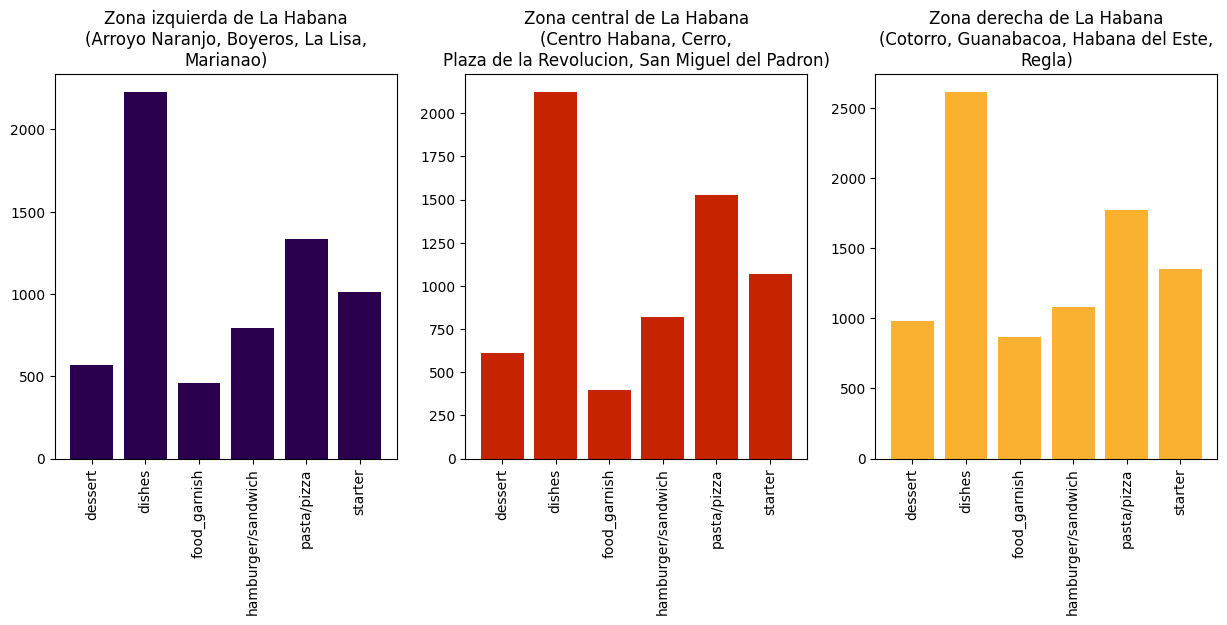

In [65]:
by_municipe = filter_lists(info, "food")

left_zones = {"mncp": "Zona izquierda de La Habana\n(Arroyo Naranjo, Boyeros, La Lisa,\nMarianao)", "values": []}
center_zones = {"mncp": "Zona central de La Habana\n(Centro Habana, Cerro,\nPlaza de la Revolucion, San Miguel del Padron)",  "values": []}
right_zones = {"mncp": "Zona derecha de La Habana\n(Cotorro, Guanabacoa, Habana del Este,\nRegla)", "values": []}

for muni in by_municipe:
    for keys, values in muni.items():
        if keys in ["AN", "BY", "LL", "MN"]:
            left_zones["values"].extend(values)
        elif keys in ["CH", "CR", "PZ", "SM"]:
            center_zones["values"].extend(values)
        else:
            right_zones["values"].extend(values)

df_lftzns = pd.DataFrame(left_zones["values"])
df_cntrzns = pd.DataFrame(center_zones["values"])
df_rghtzns = pd.DataFrame(right_zones["values"])


LZoneGroup = df_lftzns.groupby("category")["price"].mean()
CZoneGroup = df_cntrzns.groupby("category")["price"].mean()
RZoneGroup = df_rghtzns.groupby("category")["price"].mean()


graph_bar_by_zone(
    [LZoneGroup, CZoneGroup, RZoneGroup],
    ["#2A004E", "#C62300", "#FAB12F"],
    [left_zones["mncp"], center_zones["mncp"], right_zones["mncp"]]
)

# Diferencias

<p>Pues si, se puede notar una clara diferencia, pero esto es en base a los municipios que tienen 10 Restaurantes/Bares, se han excluido para este analisis los 3 municipios que tienen 30 locales, en mi caso La Habana Vieja, Diez de Octubre y Playa, que posteriormente seran analizados, pero ahora continuemos con estos graficos.</p>

<p>Pues bien, para este analisis aprovechando que se han excluido 3 municipios, nos quedarian 12, estos los repartimos entre 3 zonas de toda la capital(<span style='color: #2A004E; background-color: #fff;'>Izquierda</span>, <span style='color: #C62300;'>Centro</span> y <span style='color: #FAB12F;'>Derecha</span>).</p>

<p>En la <span style='color: #2A004E; background-color: #fff;'>zona izquierda</span> vemos que los precios medios de los <strong>platos principales ("dishes")</strong> esta por encima de los 2000 CUP, </p>

<p>En la <span style='color: #C62300;'>zona central</span> vemos lo mismo <strong>platos principales ("dishes")</strong>, y esto es normal, estamos hablando del casco historico de la ciudad, donde los turistas nacionales e internacionales visitan cada año, cada mes, cada dia; y aqui si sobrepasa los 2000 CUP, </p>